In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from tqdm.autonotebook import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [2]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")
#train_frame = train_frame.iloc[-1:]; test_frame = train_frame;

In [3]:
class TraceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        input = torch.tensor(train_frame.iloc[idx]['input'], dtype=torch.float32)
        target = torch.tensor(train_frame.iloc[idx]['target'], dtype=torch.float32)
        return input, target

train_dataset = TraceDataset(train_frame)
test_dataset = TraceDataset(test_frame)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [17]:
def bicycle_model_eval(input, last_pose):
    # This version takes in an input of dim 5
    states = []  # torch.zeros((81, 4))
    L = 0.3302
    TS = 0.1
    X, Y, THETA, V = 0, 1, 2, 3
    #states.append(torch.tensor([last_pose[0],last_pose[1],last_pose[2],input[0]], requires_grad=True))
    state = torch.zeros((4,))
    state[X] = last_pose[0]
    state[Y] = last_pose[1]
    state[THETA] = last_pose[2]
    state[V] = input[0]
    states.append(state)
    for i in range(1,81):
        # Advance bicycle model
        state = torch.zeros((4,))
        state[X] = states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA]))
        state[Y] = states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA]))
        state[THETA] = states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(input[1])) / L)
        state[V] = states[i-1][V] + TS*input[2]
        states.append(state)
        #states.append(
        #    torch.tensor(
        #        [states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA])),
        #         states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA])),
        #         states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(input[1])) / L),
        #         states[i-1][V] + TS*input[2]], requires_grad=True))
        #states[i, dX] = states[i-1,V] * torch.cos(trace[i-1,THETA])
        #states[i, dY] = states[i-1,V] * torch.sin(trace[i-1,THETA])
        #states[i, dTHETA] = (states[i-1,V] * torch.tan(input[4])) / L
        #states[i, dV] = input[5]
        #states[i, V] = states[i-1, V] + TS*states[i, dV]
    trace = torch.vstack(states)[1:,0:3]
    return trace


def custom_loss_func(prediction, target):
    loss = F.mse_loss(prediction, target)
    #loss += 10*output[0]**2 if output[0]<0 else 0
    #loss += 2*torch.linalg.norm(output)**2
    return loss

class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=10, target_size=3):
        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, target_size)
        )

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        if len(inputs.shape) == 2:
            output = torch.column_stack([F.softplus(output[:,0]), torch.tanh(output[:,1])*np.pi, output[:,2]])
        else:
            scaled_output = torch.zeros_like(output)
            scaled_output[:,:,0] = F.softplus(output[:,:,0])
            scaled_output[:,:,1] = torch.tanh(output[:,:,1])
            scaled_output[:,:,2] = output[:,:,2]
        return output
    
    def generate_trace(self, params, last_pose):
        states = []  # torch.zeros((81, 4))
        L = 0.3302
        TS = 0.1
        X, Y, THETA, V = 0, 1, 2, 3
        state = torch.zeros((4,))
        state[X] = last_pose[0]
        state[Y] = last_pose[1]
        state[THETA] = last_pose[2]
        state[V] = params[0]
        states.append(state)
        for i in range(1,81):
            # Advance bicycle model
            state = torch.zeros((4,))
            state[X] = states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA]))
            state[Y] = states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA]))
            state[THETA] = states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(params[1])) / L)
            state[V] = states[i-1][V] + TS*params[2]
            states.append(state)
        trace = torch.vstack(states)[1:,0:3]
        return trace
    
    def predict(self, inputs, horizon=80):
        if len(inputs.shape) == 2:
            # No batching here
            return self.generate_trace(self.forward(inputs)[-1], inputs[-1])
        else:
            # We have a batch dim
            output = torch.zeros((inputs.shape[0], 80, 3), dtype=torch.float32)
            response = self.forward(inputs)
            for item in range(inputs.shape[0]):
                output[item] = self.generate_trace(response[item][-1], inputs[item][-1])
            return output
            

In [18]:
net = LSTMPredictor()
net.load_state_dict(torch.load("best_simple_bicycle.pt"))

<All keys matched successfully>

In [19]:
torch.tensor(train_frame.iloc[0]['input'])

tensor([[-58.9267,  31.1195,   2.0114],
        [-59.0875,  31.4569,   2.0265],
        [-59.2471,  31.7847,   2.0320],
        [-59.4060,  32.1001,   2.0484],
        [-59.5651,  32.4038,   2.0645],
        [-59.7262,  32.6999,   2.0798],
        [-59.8943,  32.9917,   2.1144],
        [-60.0724,  33.2777,   2.1533],
        [-60.2605,  33.5560,   2.1888],
        [-60.4569,  33.8287,   2.2108]], dtype=torch.float64)

In [20]:
inp = torch.tensor(train_frame.iloc[0]['input'], dtype=torch.float32)
outp = net.predict(inp)
target = torch.tensor(train_frame.iloc[0]['target'], dtype=torch.float32)
outp.shape

torch.Size([80, 3])

In [21]:
loss = custom_loss_func(outp, target.squeeze())
loss.item()

5.9714484214782715

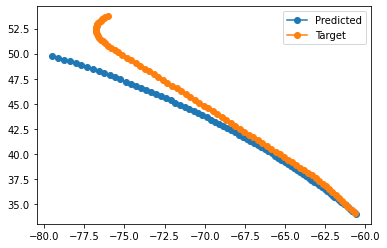

In [22]:
plt.plot(outp[:,0].detach().numpy(), outp[:,1].detach().numpy(), marker='o', label='Predicted')
plt.plot(target[:,0].detach().numpy(), target[:,1].detach().numpy(), marker='o', label='Target')
plt.legend()

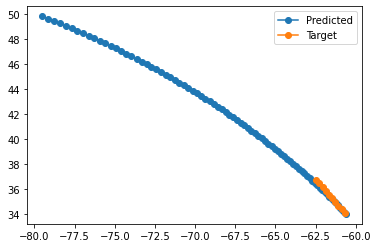

In [23]:
plt.plot(outp[:,0].detach().numpy(), outp[:,1].detach().numpy(), marker='o', label='Predicted')
plt.plot(target[:10,0].detach().numpy(), target[:10,1].detach().numpy(), marker='o', label='Target')
plt.legend()

  0%|          | 0/15 [00:00<?, ?it/s]

2.6510702741906997


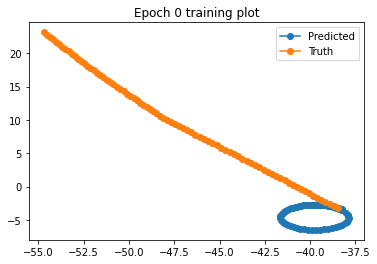

  0%|          | 0/4 [00:00<?, ?it/s]

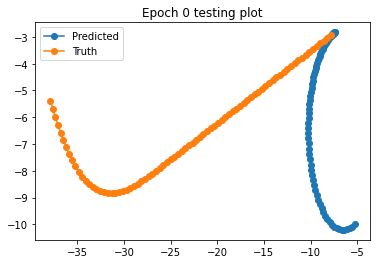

2.8607885716325145
Epoch 0 | Train Loss: 2.6510702741906997 | Test Loss: 2.8607885716325145


  0%|          | 0/15 [00:00<?, ?it/s]

2.657198820722864


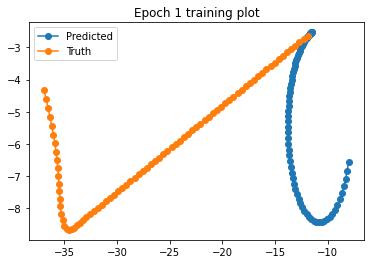

  0%|          | 0/4 [00:00<?, ?it/s]

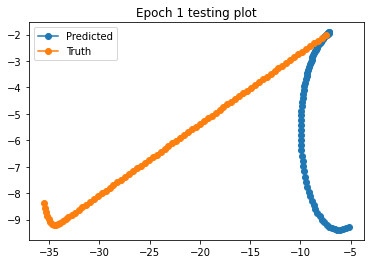

2.8575471781067927
Epoch 1 | Train Loss: 2.657198820722864 | Test Loss: 2.8575471781067927


  0%|          | 0/15 [00:00<?, ?it/s]

2.6549455845609624


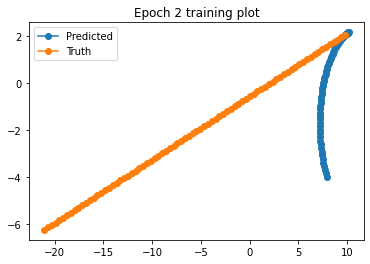

  0%|          | 0/4 [00:00<?, ?it/s]

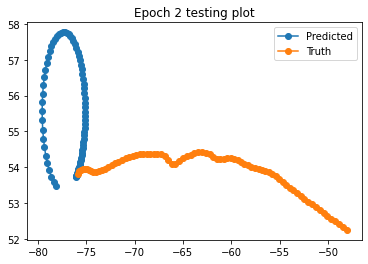

2.849007558014433
Epoch 2 | Train Loss: 2.6549455845609624 | Test Loss: 2.849007558014433


  0%|          | 0/15 [00:00<?, ?it/s]

2.6501861409938083


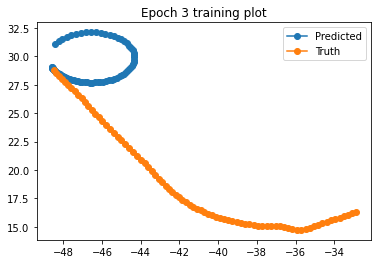

  0%|          | 0/4 [00:00<?, ?it/s]

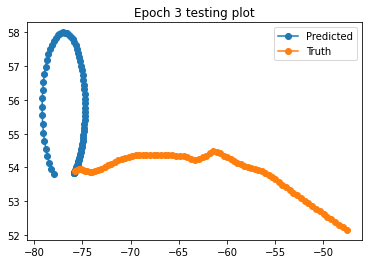

2.8616541199764964
Epoch 3 | Train Loss: 2.6501861409938083 | Test Loss: 2.8616541199764964


  0%|          | 0/15 [00:00<?, ?it/s]

2.6479185388443316


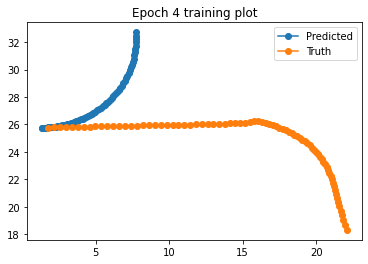

  0%|          | 0/4 [00:00<?, ?it/s]

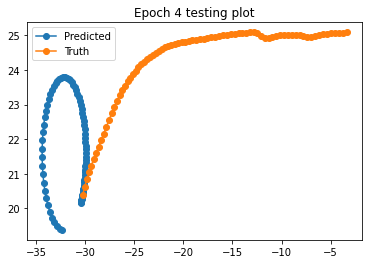

2.8785225819733182
Epoch 4 | Train Loss: 2.6479185388443316 | Test Loss: 2.8785225819733182


  0%|          | 0/15 [00:00<?, ?it/s]

2.6568516508061837


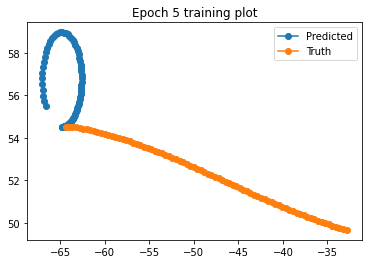

  0%|          | 0/4 [00:00<?, ?it/s]

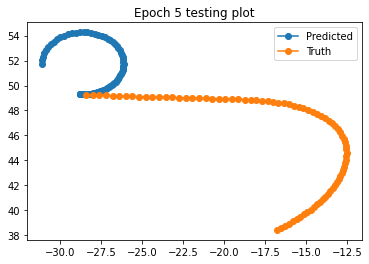

2.857873173083289
Epoch 5 | Train Loss: 2.6568516508061837 | Test Loss: 2.857873173083289


  0%|          | 0/15 [00:00<?, ?it/s]

2.652538153465758


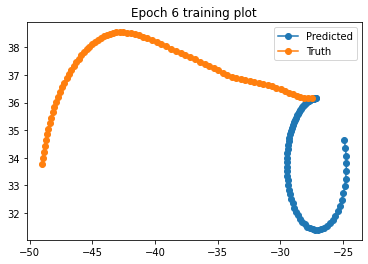

  0%|          | 0/4 [00:00<?, ?it/s]

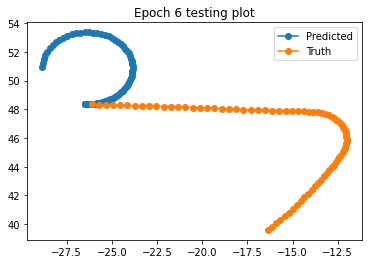

2.8556690539343883
Epoch 6 | Train Loss: 2.652538153465758 | Test Loss: 2.8556690539343883


  0%|          | 0/15 [00:00<?, ?it/s]

2.6542310349484706


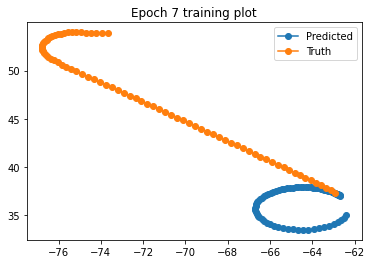

  0%|          | 0/4 [00:00<?, ?it/s]

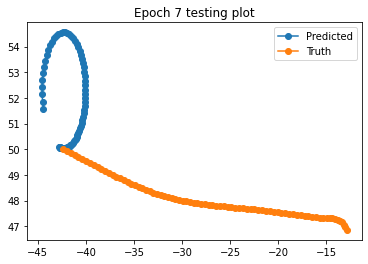

2.846050844354145
Epoch 7 | Train Loss: 2.6542310349484706 | Test Loss: 2.846050844354145


  0%|          | 0/15 [00:00<?, ?it/s]

2.651858195852726


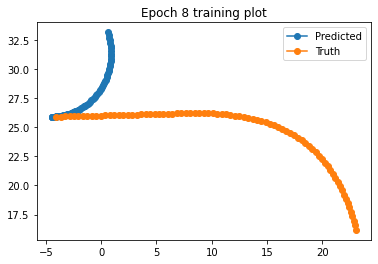

  0%|          | 0/4 [00:00<?, ?it/s]

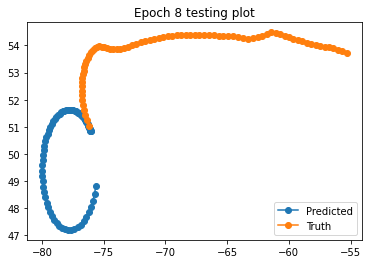

2.8541153083413335
Epoch 8 | Train Loss: 2.651858195852726 | Test Loss: 2.8541153083413335


  0%|          | 0/15 [00:00<?, ?it/s]

2.653814031722698


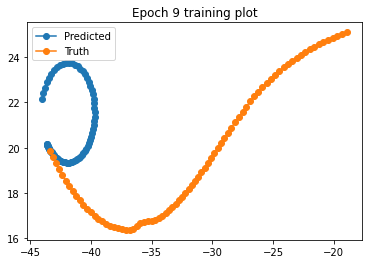

  0%|          | 0/4 [00:00<?, ?it/s]

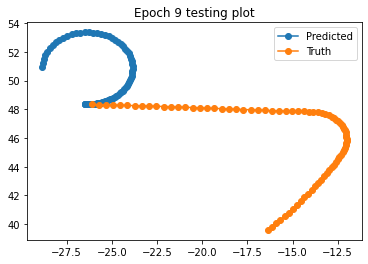

2.855207734188791
Epoch 9 | Train Loss: 2.653814031722698 | Test Loss: 2.855207734188791


  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
# Training Loop
torch.autograd.semake_dotect_anomaly(True)
net = LSTMPredictor()
net.to(DEVICE)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
train_losses = list()
test_losses = list()

for epoch in range(100):
    cum_train_loss = 0.0
    net.train()
    for input_data, target_data in tqdm(train_dataloader):
        input_data = input_data.squeeze().to(DEVICE)
        outp = net.predict(input_data)
        loss = custom_loss_func(outp, target_data)
        loss.backward()
        cum_train_loss += loss.item()
    cum_train_loss /= len(train_dataset)
    train_losses.append(cum_train_loss)
    print(cum_train_loss)
    
    plt.title(f"Epoch {epoch} training plot")
    plt.plot(outp[0,:,0].detach().cpu().numpy(), outp[0,:,1].detach().cpu().numpy(), marker='o', label="Predicted")
    plt.plot(target_data[0,:,0].detach().cpu().numpy(), target_data[0,:,1].detach().cpu().numpy(), marker='o', label="Truth")
    plt.legend()
    plt.show()
    
    cum_test_loss = 0.0
    net.eval()
    with torch.no_grad():
        for input_data, target_data in tqdm(test_dataloader):
            input_data = input_data.squeeze().to(DEVICE)
            outp = net.predict(input_data)
            loss = custom_loss_func(outp, target_data)
            cum_test_loss += loss.item()
        plt.title(f"Epoch {epoch} testing plot")
        plt.plot(outp[0,:,0].detach().cpu().numpy(), outp[0,:,1].detach().cpu().numpy(), marker='o', label="Predicted")
        plt.plot(target_data[0,:,0].detach().cpu().numpy(), target_data[0,:,1].detach().cpu().numpy(), marker='o', label="Truth")
        plt.legend()
        plt.show()
    cum_test_loss /= len(test_dataset)
    test_losses.append(cum_test_loss)
    if cum_test_loss <= min(test_losses):
        torch.save(net.state_dict(), "best_simple_bicycle_batched.pt")
    print(cum_test_loss)
    print(f"Epoch {epoch} | Train Loss: {cum_train_loss} | Test Loss: {cum_test_loss}")

In [ ]:
from viz_net import make_dot
cum_train_loss = 0.0
net.train()
for input_data, target_data in tqdm(train_dataloader):
    input_data = input_data.squeeze().to(DEVICE)
    outp = net.predict(input_data)
    loss = custom_loss_func(outp, target_data)
    loss.backward()
    cum_train_loss += loss.item()
    break
cum_train_loss /= len(train_dataset)
train_losses.append(cum_train_loss)
print(cum_train_loss)
g = make_dot(loss)
g.view()

  0%|          | 0/15 [00:00<?, ?it/s]

0.1819845645985705


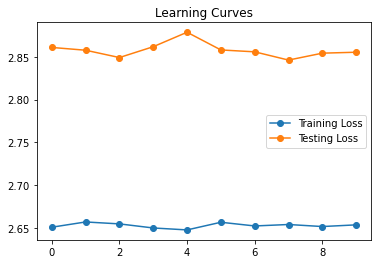

In [28]:
plt.title(f"Learning Curves")
plt.plot(train_losses, marker='o', label="Training Loss")
plt.plot(test_losses, marker='o', label="Testing Loss")
plt.legend()
plt.show()

In [ ]:
test_losses